# 任务描述

- 基于MNIST数据集，设计分类器实现手写数字分类。


# 数据描述

[MNIST](http://yann.lecun.com/exdb/mnist/)数据集，包含60,000个训练集样本与10,000个测试集样本。

每个样本是一个28\*28的灰度图：

Magic: 2051, Total Images: 60000, Size: 28*28
Magic: 2049, Total Images: 60000
Magic: 2051, Total Images: 10000, Size: 28*28
Magic: 2049, Total Images: 10000


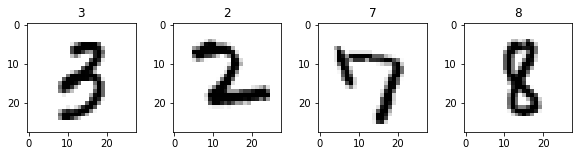

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct


def decode_idx3_ubyte(idx3_ubyte_file):
    bin_data = open(idx3_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = \
        struct.unpack_from(fmt_header, bin_data, offset)
    print('Magic: %d, Total Images: %d, Size: %d*%d' % 
          (magic_number, num_images, num_rows, num_cols))
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(
            struct.unpack_from(fmt_image, bin_data, offset)) \
            .reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    bin_data = open(idx1_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = \
        struct.unpack_from(fmt_header, bin_data, offset)
    print('Magic: %d, Total Images: %d' % (magic_number, num_images))
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i], = struct.unpack_from(fmt_image, bin_data, offset)
        offset += struct.calcsize(fmt_image)
    return labels


def prepare_dataset(images_file, labels_file, size, num=None):
    images = decode_idx3_ubyte(images_file)
    images = images.reshape((-1, size))
    labels = decode_idx1_ubyte(labels_file)
    labels = np.array(labels, dtype=np.int)
    # shuffle
    idx = np.arange(labels.shape[0])
    np.random.shuffle(idx)
    if num is not None:
        idx = idx[:num]
    images = images[idx]
    labels = labels[idx]
    return images, labels


train_images_idx3_ubyte_file = './mnist/train-images.idx3-ubyte'
train_labels_idx1_ubyte_file = './mnist/train-labels.idx1-ubyte'
test_images_idx3_ubyte_file = './mnist/t10k-images.idx3-ubyte'
test_labels_idx1_ubyte_file = './mnist/t10k-labels.idx1-ubyte'
SIZE = 28 * 28

np.random.seed(1)

train_images, train_labels = \
    prepare_dataset(train_images_idx3_ubyte_file,
                    train_labels_idx1_ubyte_file, SIZE)
test_images, test_labels = \
    prepare_dataset(test_images_idx3_ubyte_file,
                    test_labels_idx1_ubyte_file, SIZE)

plt.figure(figsize=(10, 2))
for i in range(4):
    ax = plt.subplot(141 + i)
    plt.imshow(train_images[i].reshape((28, 28)), cmap='binary')
    ax.set_title(str(train_labels[i]))
plt.show()

# 数据预处理

将图像灰度值映射到$[0,1]$之间：

In [2]:
train_images /= 255
test_images /= 255

# 算法介绍

## 卷积神经网络（CNN）

### 算法原理

![LeNet-5](images/lenet-5.png)

上图为LeNet-5（一种CNN）的架构图，该网络一共由5层构成，输入为28\*28\*1的图像（最后一维表示通道），每层详细信息如下：

1. 卷积层+池化

   6个5\*5卷积核，步长（Stride）为1\*1，图像周围补0，保证卷积输出大小与输入图像大小一致。池化层为最大池化，大小为2\*2，步长为2\*2，本层输出为14\*14\*6。


2. 卷积层+池化

   16个5\*5卷积核，步长（Stride）为1\*1，图像周围不补0，卷积输出为10\*10\*16。池化层为最大池化，大小为2\*2，步长为2\*2，本层输出为5\*5\*16。


3. 全连接

   本层将上一层输出的图像转换为一维向量，并通过全连接层，本层包含120个神经元。


4. 全连接

   本层包含84个神经元。


5. 全连接

   本层为输出层，包含10个神经元。


### 算法实现

本报告基于Tensorflow实现卷积神经网络（TF-CNN）：

In [ ]:
import tensorflow as tf


class CNN:

    def __init__(self, height=28, weight=28, n_channels=1,
                 n_filters_1=6, n_filters_2=16,
                 n_hidden_1=120, n_hidden_2=84, n_classes=10):
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=[None, height, weight, n_channels])
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=[None, n_classes])
        self.training = False
        # layer 1 - conv
        # (N, 28, 28, 1) -> (N, 28, 28, 6) -> (N, 14, 14, 6)
        x = tf.layers.conv2d(self.X, n_filters_1, [5, 5], padding='same')
        x = tf.nn.relu(x)
        self.conv1 = x  # layer 1: convolution output
        x = tf.layers.max_pooling2d(x, [2, 2], [2, 2])
        self.max_pooling1 = x  # layer 1: max pooling output
        # layer 2 - conv
        # (N, 14, 14, 6) -> (N, 10, 10, 16) -> (N, 5, 5, 16)
        x = tf.layers.conv2d(x, n_filters_2, [5, 5])
        x = tf.nn.relu(x)
        self.conv2 = x  # layer 2: convolution output
        x = tf.layers.max_pooling2d(x, [2, 2], [2, 2])
        self.max_pooling2 = x  # layer 2: max pooling output
        # flatten
        x = tf.layers.flatten(x)  # (N, 400)
        # layer 3 - fully connected
        x = tf.layers.dense(x, n_hidden_1)  # (N, 120)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, training=self.training)
        # layer 4 - fully connected
        x = tf.layers.dense(x, n_hidden_2)  # (N, 84)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, training=self.training)
        # layer 5 - fully connected
        x = tf.layers.dense(x, n_classes)  # (N, 10)
        self.pred = x
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y,
                                                       logits=self.pred))
        optimizer = tf.train.AdamOptimizer()
        grads_and_vars = optimizer.compute_gradients(self.loss)
        self.train_op = optimizer.apply_gradients(grads_and_vars)


def channel_first(x):
    h, w, c = x.shape
    y = np.zeros((c, h, w))
    for k in range(c):
        for i in range(h):
            for j in range(w):
                y[k, i, j] = x[i, j, k]
    return y


# visualization
def show(conv, max_pooling, pos, name, layer):
    conv = channel_first(conv)
    max_pooling = channel_first(max_pooling)
    n, _, _ = conv.shape
    for i in range(n):
        ax = plt.subplot(6, n, n * pos * 2 + i + 1)
        ax.imshow(conv[i] / np.max(conv[i]) * 255, cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(name + '@conv' + str(layer), fontsize='small')
    for i in range(n):
        ax = plt.subplot(6, n, n * pos * 2 + n + i + 1)
        ax.imshow(max_pooling[i] / np.max(max_pooling[i]) * 255, cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(name + '@pool' + str(layer), fontsize='small')


def evaluate(model):
    # evaluate
    model.training = False
    if test_flag:
        conv1, max_pooling1, conv2, max_pooling2, pred = sess.run([
            model.conv1, model.max_pooling1,
            model.conv2, model.max_pooling2,
            tf.argmax(model.pred, axis=-1)],
            feed_dict={
                model.X: test_images
            })
        all_set = [1, 43, 57]
        plt.figure(figsize=(10, 2))
        for i, N in enumerate(all_set):
            ax = plt.subplot(1, 3, 1 + i)
            ax.imshow(test_images[N].reshape((28, 28)), cmap='binary')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(chr(ord('A') + i), y=-0.2, fontsize='small')
        plt.savefig('images/0.png', bbox_inches='tight')
        plt.figure(figsize=(10, 11))
        for i, N in enumerate(all_set):
            show(conv1[N], max_pooling1[N], i, chr(ord('A') + i), 1)
        plt.savefig('images/1.png', bbox_inches='tight')
        plt.figure(figsize=(10, 5))
        for i, N in enumerate(all_set):
            show(conv2[N], max_pooling2[N], i, chr(ord('A') + i), 2)
        plt.savefig('images/2.png', bbox_inches='tight')
    else:
        pred = sess.run(tf.argmax(model.pred, axis=-1), feed_dict={
            model.X: test_images
        })
    correct = np.sum(pred == test_labels)
    acc = correct / test_labels.shape[0]
    print('accuracy:',
          correct, '/', test_labels.shape[0],
          '=', acc)
    return acc


batch_size = 500
n_epochs = 100

test_flag = False  # train/test switch

train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))
idx = np.arange(train_images.shape[0], dtype=np.int)
train_labels = np.eye(10)[train_labels]

best = 0

with tf.Graph().as_default():
    tf.set_random_seed(1)
    classifier = CNN()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        if test_flag:
            saver.restore(sess, 'model/cnn.ckpt')
            evaluate(classifier)
        else:
            sess.run(tf.global_variables_initializer())
            for epoch in range(n_epochs):
                print('epoch', epoch)
                # train
                classifier.training = True
                np.random.shuffle(idx)
                for k in range(0, train_images.shape[0], batch_size):
                    batch_idx = idx[k:min(k + batch_size,
                                          train_images.shape[0])]
                    batch_image = train_images[batch_idx]
                    batch_label = train_labels[batch_idx]
                    sess.run(classifier.train_op, feed_dict={
                        classifier.X: batch_image,
                        classifier.y: batch_label
                    })
                # evaluate
                accuracy = evaluate(classifier)
                if accuracy > best:
                    best = accuracy
                    saver.save(sess, 'model/cnn.ckpt')
                    print('saved')
            print('-' * 30)
            print('best:', best)

# 实验结果与分析

本报告使用正确率作为评价指标，正确率是分类器正确分类的数量与测试集总量的比值。


## 实验结果

|模型|准确率|
|:-:|:-:|
|TF-MLP-NN-Sqr|0.9156|
|TF-MLP-NN-BCE|0.9813|
|TF-CNN|0.9919|

*TF-MLP-NN-Sqr与TF-MLP-NN-BCE为上次实验中实现的使用不同激活函数与损失函数的MLP-NN。*


## 实验结果分析

实验中，TF-CNN预测性能超过TF-MLP-NN-BCE与TF-MLP-NN-Sqr等MLP-NN模型。


## 可视化

从测试集中选取3张数字2，可视化TF-CNN两层卷积层后的结果：

原始图像：

![0](images/0.png)

第1层卷积层：

![1](images/1.png)

第2层卷积层：

![2](images/2.png)

卷积层用于图像的特征提取，可视化结果展示数字2经过每层卷积层后的图像，经过2层卷积层，原始图像被抽象为算法可以更好识别的高级特征，特征提取以后经过全连接层，达到更好的预测效果。